# EDA

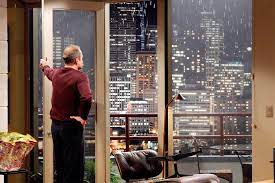

## Prepare notebook

In [ ]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from urllib.request import urlopen
import json
import plotly.io as pio
import kaleido


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Client
- name: William Rodriguez	
- type: Buyer	
- household: 2 people, 
- needs: 
    - country house (best timing & non-renovated)
    - city house (fast & central location)


## Task
1. Through EDA/statistical analysis above please come up with **AT LEAST 3 insights regarding the overall data**. One should be geographical.
1. In addition also come up with **AT LEAST 3 recommendations** for your client.

## Overall questions and insights
- average sizes, numbers of rooms etc
- average price, cyclicality of prices
- correlation: size and no rooms
- (geo)

## Client specific questions and insights
- country house: 
    - cyclicality of prices for the specific subgroup
    - non-renovated: price vs renovated for same number of rooms
    - price by lot size vs price by house size vs price by room number

- city house: location analysis based on zipcode
    - correlation size vs price 
    - correlation size vs room size 

## Data load

In [ ]:
# import data
df = pd.read_csv('data/eda.csv')
df.head()
# df.columns

## Initial data inspection
- **shape**: 21,597 observations of 22 variables
- **variable names**: all variable names are Pythonic
- **variable types**: all variable types are appropriate apart from date: it is an `object`, when it should be `datetype64`
- **variable encoding**: fix year built by dividing by 10

We have invormation about: 
- price,
- location and size of plot,
- number of floors,
- number, size and type of rooms, 
- dates of construction, last renovation and condition. 


(Interesting find: for `int` type does not support missing values, so Python default chooses type `float`. If I try turning it into `int` I get the error `IntCastingNaNError`, which in Pythonic


In [ ]:
## DATA SHAPE & VARNAMES

print(df.shape)
print("\n")
print(df.columns)


# notes: 
    # seems that variable names are okay (all "Pythonic")

In [ ]:
## INSPECTION OF VARIABLE VALUES
df.describe()

# even categorical variables are in numeric form, yay! 
# Year renovated is a mess though. Fix in next cell.

In [ ]:
## FIX YEAR RENOVATED
# year renovated has an extra 0 at the end. Divide by 10 to fix.
df['yr_renovated'] = df.yr_renovated.apply(lambda x: x/10)
df.loc[df.yr_renovated != 0].yr_renovated.describe()

## FIX ZIPCODE
df['zipcode'] = df.zipcode.astype('str')

In [ ]:
## DATA TYPES

print(df.dtypes)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.head()

# problematic types
    # date is an object --> turn into date using datetime()
    # waterfront, view, yr_renovated --> turn into int

# df = df.astype({'yr_renovated': int})
# !!interesting find!!: int cannot be NA --> python automatically chose float for int value variables

type(df.waterfront.unique()[1])
df.waterfront.unique()

## Missing values
- sales information has no missing values, only some house characteristics are missing --> perform analysis of missing values on a set of unique houses only (21,420 houses)


- missing values for 4 variables: 
    - `waterfront`: 2360 missings (11.02%)
    - `view`: 63 missings (0.29%)
    - `sqft_basement`: 451 missings (2.11%)
    - `yr_renovated`: 3811 missings (17.79%)



- the missing values are not correlated: there is no systematic relationship among missing values

- I deal with missing values by imputing 0s. This means: 
    - `waterfront`: assume house is not on waterfront
    - `view`: assume house is without a view
    - `sqft_basement`: assume house has no basement
    - `yr_renovated`: assume house was not renovated

In [ ]:
## INSPECT MISSING  VALUES
df.isna().sum() #
houses = df.drop(['sale_id', 'date', 'price'], axis = 1).drop_duplicates()
# houses.isna().sum()

# print shares of missing values
for key, value in dict(houses.isna().sum()).items(): 
    if value != 0:
        print(f"- `{key}`: {value} missings ({round(value/len(houses)*100, 2)}%)")
    # houses.waterfront.isna().sum()/len(houses)*100

In [ ]:
# msno.heatmap(houses)
# very little correlation among missing variables: no systematic issues

In [ ]:
## Fill missing values with 0s
df = df.fillna(0)

# df.isna().sum() --> no missing values anymore, yay!

## Summary statistics
- histograms for some of the numerical variables
- ANYTHING INTERESTING?!?!



In [ ]:
df.describe()

In [ ]:
# df.grade.value_counts()

## General insight 1: 
- There is a great variety of properties being sold and bought
- Majority of the houses: 
    - cost below 500k
    - are below 2000sqft (185sqm)
    - have a lot size of < 7500 sqft (700sqm)
    - have 3 or fewer bedrooms

In [ ]:
cols = ['price', 'sqft_living', 'sqft_lot', 'yr_built', 'bedrooms', 'bathrooms']


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# plt.hist(df.price, edgecolor='black', normalize = 1)  # Adjust the number of bins as needed

axes = axes.flatten()

# Plot normalized histograms for each variable
for i, var in list(zip(range(8), cols)) :
    axes[i].hist(df[var], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{var}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Probability Density')

    # add mean and median
    mean_value = np.mean(df[var])
    median_value = np.median(df[var])
    axes[i].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Avg: {mean_value:.2f}')
    axes[i].axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Med: {median_value:.2f}')

    axes[i].legend()

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

## General insight 2
- 

In [ ]:
# price per sqft over time

df['month'] = df.date.dt.month
df['year'] = df.date.dt.year
df['year_month'] = df.date.dt.strftime('%Y-%m')

df['price_sqft'] = df['price']/df['sqft_living']

price_sqft_month = df.groupby(['year','month', 'year_month']).price_sqft.mean().reset_index() 


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# plt.hist(df.price, edgecolor='black', normalize = 1)  # Adjust the number of bins as needed

axes = axes.flatten()

# Plot normalized histograms for each variable

axes[0].hist(df['price_sqft'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title(f'Price per square foot')
axes[0].set_xlabel('Price (per sqft)')
axes[0].set_ylabel('Probability Density')

mean_value = np.mean(df['price_sqft'])
median_value = np.median(df['price_sqft'])
axes[0].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Avg: {mean_value:.2f}$')
axes[0].axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Med: {median_value:.2f}$')
axes[0].legend()

plt.plot(price_sqft_month.year_month, price_sqft_month.price_sqft, marker = 'o')
axes[1].set_title('Sqft price over time')
axes[1].set_xlabel('')
axes[1].set_ylabel('Price per sqft (in $)')
plt.xticks(rotation = 90)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


## Specific insight 2: correlation between grade and price

In [ ]:
grade_price = df[['grade', 'price_sqft', 'zipcode']].groupby('zipcode').agg('mean').reset_index()
grade_price.head()

plt.scatter(grade_price.grade, grade_price.price_sqft)

In [ ]:
## Geographical insight goes here

with urlopen('https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/wa_washington_zip_codes_geo.min.json') as response:
    zipcodes = json.load(response)

price_by_zipcode = df.groupby('zipcode').agg({'price': 'mean', 'price_sqft': 'mean'}).reset_index()
# price_by_zipcode['zipcode'] = df.zipcode.astype('str')
price_by_zipcode.head()

import plotly.express as px

fig = px.choropleth_mapbox(price_by_zipcode, geojson=zipcodes, locations='zipcode', color='price_sqft',
                           color_continuous_scale="Viridis",
                           range_color=(price_by_zipcode.price_sqft.min(), price_by_zipcode.price_sqft.max()),
                           mapbox_style="carto-positron",
                           zoom=8, center = {"lat": 47.553306, "lon": -122.237702}, 
                           featureidkey="properties.ZCTA5CE10",
                           opacity=0.5,
                           labels={'price':'average house price'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


# pio.write_image(fig, 'graphs/i3_map_price_sqft.jpeg')

In [ ]:
price_by_zipcode.describe()
# by_zipcode.shape
df.columns

## Specific insight 1
-- country house: 
    - what is a country house? 
    - share of non-renovated houses on the market (to see velocity)

In [ ]:
df['land_to_house'] = df.sqft_lot / df.sqft_living
df.land_to_house.describe()

size_by_zipcode = df.groupby('zipcode').agg({'land_to_house': 'mean'}).reset_index()
# size_by_zipcode['zipcode'] = df.zipcode.astype('str')
size_by_zipcode.head()

fig = px.choropleth_mapbox(size_by_zipcode, geojson=zipcodes, locations='zipcode', color='land_to_house',
                           color_continuous_scale="Viridis",
                           range_color=(np.percentile(size_by_zipcode.land_to_house, 20), np.percentile(size_by_zipcode.land_to_house, 80)),
                           mapbox_style="carto-positron",
                           zoom=8, center = {"lat": 47.553306, "lon": -122.237702}, 
                           featureidkey="properties.ZCTA5CE10",
                           opacity=0.5
                        #    labels={'price':'average house price'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

country = df.loc[df.land_to_house >= 5]
country.shape


In [ ]:
king_zips = pd.read_csv('data/uszips.csv', dtype= str)
king_zips.head()

king_zips = pd.DataFrame(king_zips).loc[king_zips.county_fips == "53033", ['zip', 'density', 'city']]
king_zips['density'] = king_zips.density.astype('float')
king_zips = king_zips.rename(columns = {'zip': 'zipcode'})
king_zips.head()
# king_zips.describe()
# king_zips.shape



In [ ]:
fig = px.choropleth_mapbox(king_zips, geojson=zipcodes, locations='zipcode', color='density',
                           color_continuous_scale="Viridis",
                           range_color=(king_zips.density.min(),5000),
                           mapbox_style="carto-positron",
                           zoom=8, center = {"lat": 47.553306, "lon": -122.237702}, 
                           featureidkey="properties.ZCTA5CE10",
                           opacity=0.5
                        #    labels={'price':'average house price'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
# source: https://simplemaps.com/data/us-zips

In [ ]:
df = pd.merge(df, king_zips, how = 'left', on = 'zipcode')
df['country'] = df.density.apply(lambda x: 1 if x < 500 else 0)
df.loc[df.country == 1].head()

In [ ]:
country_by_zipcode = df.groupby('zipcode').agg({'country': 'mean'}).reset_index()
country_by_zipcode['country_cat'] = country_by_zipcode.country.apply(lambda x: "yes" if x == 1 else "no")
country_by_zipcode.head()


fig = px.choropleth_mapbox(country_by_zipcode, geojson=zipcodes, color="country_cat",
                           locations="zipcode", featureidkey="properties.ZCTA5CE10",
                           zoom=8, center = {"lat": 47.553306, "lon": -122.237702}, 
                           color_discrete_sequence=["LightCoral", "LightSkyBlue"],
                           opacity = 0.7, 
                           mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
print(f"There are {df.loc[(df.country == 1)].sale_id.count()} being sold in the country, {round(df.loc[(df.country == 1)].sale_id.count()/len(df)*100, 2)}%")


country = df.loc[(df.country == 1) & (df.land_to_house >= 5)]
print(f"Of the houses in the country, {len(country)} ({round(len(country)/df.loc[(df.country == 1)].sale_id.count(), 2)*100}%) have the minimum land-to-house ratio.")

country['renovated'] = country.yr_renovated.apply(lambda x: "yes" if x != 0 else "no")
print(f"Of those houses, {len(country.loc[country.renovated == 'no'])} not renovated.")

country = country.loc[country.renovated == 'no']

country.grade.value_counts()
# country.shape


In [ ]:
# px.density_mapbox(df, lat = '', long = 'long', radius, mapbox_style = "open-street-map")
country_price_month = country.groupby(['year','month', 'year_month']).price_sqft.mean().reset_index() 
country_price_month.head()

country_price_zipcode = country.groupby(['zipcode']).agg({'price_sqft': 'mean', 'grade': 'mean'}).reset_index().sort_values(by = ['price_sqft'], ascending = 0)
country_price_zipcode.head()

# country_grade_zipcode = 


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# plt.hist(df.price, edgecolor='black', normalize = 1)  # Adjust the number of bins as needed

axes = axes.flatten()

# Plot normalized histograms for each variable

axes[0].bar(country_price_zipcode.zipcode, country_price_zipcode['price_sqft'])
axes[0].set_title('Mean price per zipcode')
axes[0].set_ylabel('Price (per sqft)')
axes[0].set_xlabel('')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_ylim(150,300)
plt.xticks(rotation = 90)

# Create a secondary y-axis for the first subplot
axes2_0 = axes[0].twinx()
axes2_0.scatter(country_price_zipcode.zipcode, country_price_zipcode.grade, color='red', label='')
axes2_0.set_ylabel('Grade (0-13)')
axes2_0.tick_params(axis='y')

axes[1].plot(country_price_month.year_month, country_price_month.price_sqft, marker = 'o')
axes[1].set_title('Sqft price over time')
axes[1].set_xlabel('')
axes[1].set_ylabel('Price per sqft (in $)')
axes[1].set_ylim(200,250)
plt.xticks(rotation = 90)



# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()
plt.savefig('graphs/s2_price_analysis_country.png')

## Specific insight 2
- what is important? 
    - size
    

In [ ]:
city = df.loc[(df.city == 'Seattle')]
city.shape

print(f'There were {city.shape[0]} houses sold in Seattle city ({round(city.shape[0]/len(df)*100, 2)}% of all houses).')
print(f'This includes {city.zipcode.nunique()} zipcodes in the King County.')

city = city.loc[(city.bedrooms <= 5)]

print(f'Out of those {city.shape[0]} were houses with 5 or fewer bedrooms.')
# plt.show()
# city.head()

In [ ]:
by_bedrooms = city.groupby('bedrooms').agg({'sale_id': 'count'}).reset_index().rename(columns= {'sale_id': 'count_sales'})
by_bedrooms.head()

plt.bar(by_bedrooms['bedrooms'], by_bedrooms['count_sales'])
plt.xlabel('Number of bedrooms')
plt.ylabel('Count of sales')
plt.title('')

In [ ]:
by_zipcode = city.groupby(['zipcode', 'year_month']).agg({'sale_id': 'count'}).reset_index().rename(columns= {'sale_id': 'sales_month'})
by_zipcode = by_zipcode.groupby('zipcode').agg({'sales_month': 'mean'}).reset_index()
by_zipcode.head()

In [ ]:
fig = px.choropleth_mapbox(by_zipcode, geojson=zipcodes, locations='zipcode', color='sales_month',
                           color_continuous_scale="Viridis",
                           range_color=(by_zipcode.sales_month.min(),by_zipcode.sales_month.max()),
                           mapbox_style="carto-positron",
                           zoom=9.5, center = {"lat": 47.5528, "lon": -122.335212}, 
                           featureidkey="properties.ZCTA5CE10",
                           opacity=0.5,
                           labels={'sales_month':'sales per month'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(height=800, width=800)
fig.show()

In [ ]:
velocity_zips = list(by_zipcode.loc[by_zipcode.sales_month > 30].zipcode)
print(velocity_zips)

# high_velocity = city[(city.zipcode.isin(velocity_zips)) & (city.bedrooms.isin(range(2, 5)))].groupby(['zipcode', 'bedrooms']).agg({'price': 'mean', 'price_sqft': 'mean'}).reset_index()

high_velocity = city[(city.zipcode.isin(velocity_zips)) & (city.bedrooms.isin(range(2, 5)))]
high_velocity.head()
high_velocity.grade.value_counts()

In [ ]:
sns.boxplot(x = 'bedrooms', y = 'price', data = high_velocity)

In [ ]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# plt.hist(df.price, edgecolor='black', normalize = 1)  # Adjust the number of bins as needed

axes = axes.flatten()

sns.barplot(data = high_velocity, x = 'zipcode', y = 'price', hue = 'bedrooms', ax = axes[0])
sns.barplot(data = high_velocity, x = 'zipcode', y = 'price_sqft', hue = 'bedrooms', ax  = axes[1])

plt.show()
plt.clf()
